In [ ]:
# -- 네이버 영화리뷰 감성분석 
# 네이버의 영화 감상평을 이용하여 내용의 긍정/부정 여부를 판단하는 모듈

1. PC환경설정

  한국어 형태소 분석기 konlpy와 JAVA jdk설치

In [1]:
import os
!apt-get update 
!apt-get install g++ openjdk-8-jdk python-dev python3-dev 
!pip3 install JPype1-py3 
!pip3 install konlpy 
!JAVA_HOME="C:\Program Files\Java\jdk-15.0.2"

!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:8 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [44.4 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:13 https://developer.download.nvi

2. 영화감상평 데이타 전처리

  이미 구분된 train data와 test data 읽기

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
# 데이터를 읽어봅시다. 
train_data = pd.read_table('../content/ratings_train.txt')
test_data = pd.read_table('../content/ratings_test.txt')
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


  1) 데이타 정제
    
    - 중복데이타 제거

In [11]:
train_data.info(), test_data.info()  # 전체 데이타 확인

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146183 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        146183 non-null  int64 
 1   document  146182 non-null  object
 2   label     146183 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49158 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        49158 non-null  int64 
 1   document  49157 non-null  object
 2   label     49158 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


(None, None)

In [14]:
# 중복데이타 확인 후 삭제
print('총 샘플의 수 :',len(train_data))
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('중복제거 후 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183
중복제거 후 샘플의 수 : 146183


In [18]:
# NaN데이타 존재 확인

print(train_data.isnull().values.any(), '\n')
print(train_data.isnull().sum())     # document열에 null값 1개 존재

True 

id          0
document    1
label       0
dtype: int64


In [19]:
train_data.loc[train_data.document.isnull()] # loc를 사용하여 Null값 인덱스 확인

,id,document,label
25857,2172111,NaN,1


In [21]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any(), '\n') # Null 값이 존재하는지 확인
print('Null제거 후 샘플의 수 :',len(train_data))

False 

Null제거 후 샘플의 수 : 146182


In [22]:
# test데이타에도 동일하게 중복데이타와 Null데이타 제거
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 duplicates로 중복 제거
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49157


2) 불필요한 문자제거

  - train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인
  - train_data로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용

In [23]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [25]:
# train_data에 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, 다시 한 번 Null 값이 존재하는지 확인
train_data['document'].replace('', np.nan, inplace=True) # document의 공백을 Null로 변경
print(train_data.isnull().sum(), '\n') # Null 총 합 확인
print(train_data.loc[train_data.document.isnull()][:5])  # 샘플 확인

id            0
document    391
label         0
dtype: int64 

           id document  label
584   7117896      NaN      0
593   6478189      NaN      0
638   9364602      NaN      0
668   1600635      NaN      0
1559  6918082      NaN      1


In [26]:
# null 데이타 제거
train_data = train_data.dropna(how = 'any') # dropna로 제거
print('불필요한 한글 제거 후 샘플의 개수 :', len(train_data))

불필요한 한글 제거 후 샘플의 개수 : 145791


In [27]:
# test데이타에도 동일하게 적용
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'].replace('', np.nan, inplace=True) # document의 공백을 Null로 변경
test_data = test_data.dropna(how = 'any') # dropna로 제거
print('불필요한 한글 제거 후 test용 샘플의 개수 :', len(test_data))

불필요한 한글 제거 후 test용 샘플의 개수 : 48995


3) 토큰화

  - Okt는 위와 같이 KoNLPy에서 제공하는 형태소 분석기
  - 한국어을 토큰화할 때는 영어처럼 띄어쓰기 기준으로 토큰화를 하는 것이 아니라, 
  - 주로 형태소 분석기를 사용
  - stem = True를 사용하면 일정 수준의 정규화
  - 예제의 결과를 보면 '이런'이 '이렇다'로 변환되었고 '만드는'이 '만들다'로 변환

In [28]:
# train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장
tokenizer = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
def load_data(train_data, test_data, num_words=10000):     # 빈도가 높은 단어 10000개 추출
    # train_data.drop_duplicates(subset=['document'], inplace=True)
    # train_data = train_data.dropna(how = 'any') 
    # test_data.drop_duplicates(subset=['document'], inplace=True)
    # test_data = test_data.dropna(how = 'any') 
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

index_to_word = {index:word for word, index in word_to_index.items()}


In [29]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))
type(X_train)

훈련 샘플 개수: 145791, 테스트 개수: 48995


list

  - 빈 샘플(empty samples) 제거

In [30]:
# 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아옴
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
print(len(drop_train))

408


In [31]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145383
145383


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


4) 패딩

  - 서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.22376068728806


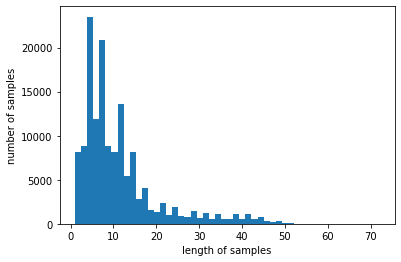

In [40]:
# 리뷰의 평균길이 확인
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

  - 가장 긴 리뷰의 길이는 72
  - 전체 데이터의 길이 분포는 대체적으로 약 11내외
  - 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있다.
  - 특정 길이 변수를 max_len으로 정한다.

In [41]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt += 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30    # 최대 길이를 30으로
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 93.74479822262576


In [42]:
print(X_train[0:10])  # 데이타 확인

[list([43, 420, 11, 6601, 627])
 list([908, 422, 34, 570, 4, 185, 1524, 15, 942, 6039, 2])
 list([360, 2816, 2, 2649, 7329, 2, 192, 7])
 list([8584, 92, 2, 208, 49, 67, 17, 4340])
 list([1008, 2, 20, 2, 15, 6412, 4, 2973, 14, 5283, 2, 443, 2, 2, 1073, 3612, 4529])
 list([691, 7330, 963, 2, 397, 128, 1836, 1749, 2, 2, 4, 81, 112, 1079, 563, 211])
 list([184, 285, 5, 297, 2, 217])
 list([112, 1079, 148, 305, 721, 2, 2, 265, 110, 1692, 343, 107, 196, 8, 774, 12, 347, 541, 475, 2, 3679, 2, 10, 1455, 1455, 29, 246, 67, 15, 27, 35, 33, 10, 669, 1065, 59])
 list([83, 2, 49, 77, 343, 376, 4])
 list([1627, 17, 2, 497, 68, 10, 363, 1513, 332, 2, 6, 2, 1088])]


In [43]:
# 데이타 확인
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

더빙 진짜 짜증나네요 목소리
라벨:  0
1번째 리뷰 문장 길이:  5
2번째 리뷰 문장 길이:  11


In [44]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))


문장길이 평균 :  11.209334389694307
문장길이 최대 :  72
문장길이 표준편차 :  9.316909571186505
pad_sequences maxlen :  29
전체 문장의 0.9331508709833417%가 maxlen 설정값 이내에 포함됩니다. 


pad_sequences()는 길이가 같지 않고 적거나 많을 때 일정한 길이로 맞춰 줄 때 사용한다.

In [45]:
# max_len으로 padding
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(X_train.shape)
print(X_test.shape)

(145383, 29)
(48995, 29)


3. LSTM으로 네이버 영화 리뷰 감성 분류

  - 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)
  - ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

In [46]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)
# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
# [[YOUR CODE]]
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(16))   
# 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 16로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 162,257
Trainable params: 162,257
Non-trainable params: 0
_________________________________________________________________


In [51]:
# 모델설정
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [52]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    callbacks=[es, mc],
                    batch_size=60,
                    validation_split=0.2)


model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/20
1939/1939 [==============================] - 22s 7ms/step - loss: 0.4973 - accuracy: 0.7291 - val_loss: 0.3950 - val_accuracy: 0.8247
Epoch 2/20
1939/1939 [==============================] - 12s 6ms/step - loss: 0.3595 - accuracy: 0.8371 - val_loss: 0.3649 - val_accuracy: 0.8365
Epoch 3/20
1939/1939 [==============================] - 12s 6ms/step - loss: 0.3439 - accuracy: 0.8476 - val_loss: 0.3574 - val_accuracy: 0.8411
Epoch 4/20
1939/1939 [==============================] - 12s 6ms/step - loss: 0.3371 - accuracy: 0.8511 - val_loss: 0.3633 - val_accuracy: 0.8432
Epoch 5/20
1939/1939 [==============================] - 12s 6ms/step - loss: 0.3270 - accuracy: 0.8568 - val_loss: 0.3495 - val_accuracy: 0.8453
Epoch 6/20
1939/1939 [==============================] - 12s 6ms/step - loss: 0.3235 - accuracy: 0.8594 - val_loss: 0.3491 - val_accuracy: 0.8466
Epoch 7/20
1939/1939 [==============================] - 13s 7ms/step - loss: 0.3145 - accuracy: 0.8634 - val_loss: 0.3564 - val_ac

In [54]:
results = model.evaluate(X_test,  y_test, verbose=2)
print("\n 테스트 정확도: %.4f" % (results[1]))

1532/1532 - 3s - loss: 0.3738 - acc: 0.8348

 테스트 정확도: 0.8348


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


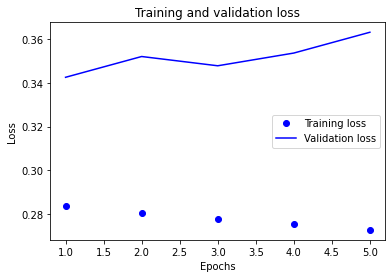

In [56]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들
import matplotlib.pyplot as plt
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

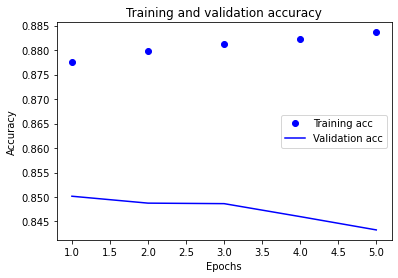

In [57]:
plt.clf()   # 그림을 초기화합니다
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()